<a href="https://colab.research.google.com/github/abyanrifqy/ProjectSingkat/blob/master/Bedroom%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bedroom Classification

In this file, we made Bedroom classification for classifying Bedroom is considered as poor or not. The output would be a binary number whether the object exist or not in csv. The output will be used for weighting parameter.

We are refering to [Coursera transfer learning course](https://github.com/lmoroney/dlaicourse/blob/1f240742b26dd336613ed69a6d44e1d6781a147c/Course%202%20-%20Part%206%20-%20Lesson%203%20-%20Notebook.ipynb) for create and training model.

In [ ]:
! git clone https://github.com/lmoroney/dlaicourse.git

Cloning into 'dlaicourse'...
remote: Enumerating objects: 3232, done.
remote: Total 3232 (delta 0), reused 0 (delta 0), pack-reused 3232
Receiving objects: 100% (3232/3232), 33.55 MiB | 24.54 MiB/s, done.
Resolving deltas: 100% (1611/1611), done.
Checking out files: 100% (564/564), done.


## Create the Model

In [ ]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import os
import pandas as pd
import keras
from tensorflow.keras import layers # pick to pick at the layers, which ones we want to use and which ones we want to retrain.
from tensorflow.keras import Model
from keras.regularizers import l2



print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.10
Tensorflow version: 2.5.0
Keras version: 2.5.0


In [ ]:
# get datasets from google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#train_dir = '/content/gdrive/MyDrive/Rangkuman Bangkit/Project Datasets/Object Detection/traincoco2017'
#validation_dir = '/content/gdrive/MyDrive/Rangkuman Bangkit/Project Datasets/Object Detection/validationcoco2017'

train_dir = '/content/gdrive/Shareddrives/Capstone Project/Bedroom/Train'
validation_dir = '/content/gdrive/Shareddrives/Capstone Project/Bedroom/Validation'

In [ ]:
BATCH_SIZE = 128
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)
pre_trained_model = tf.keras.applications.Xception(input_shape = IMG_SHAPE, 
                                include_top = False,
                                weights='imagenet', pooling='avg')
#local_weights_file = '/content/mobilenet_2_5_224_tf_no_top.h5'                               
#pre_trained_model.load_weights(local_weights_file)

print(pre_trained_model)
print(len(pre_trained_model.layers))

83689472/83683744 [==============================] - 1s 0us/step
133


In [ ]:
# We choose 110 layers to be freezed and others are unfreezed. If we set all layers are true, colab will crash.

for layer in pre_trained_model.layers[:110]:
  layer.trainable = False

for layer in pre_trained_model.layers[110:]:
  layer.trainable = True

### Analyzing the model

In [ ]:
pre_trained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Plot the model

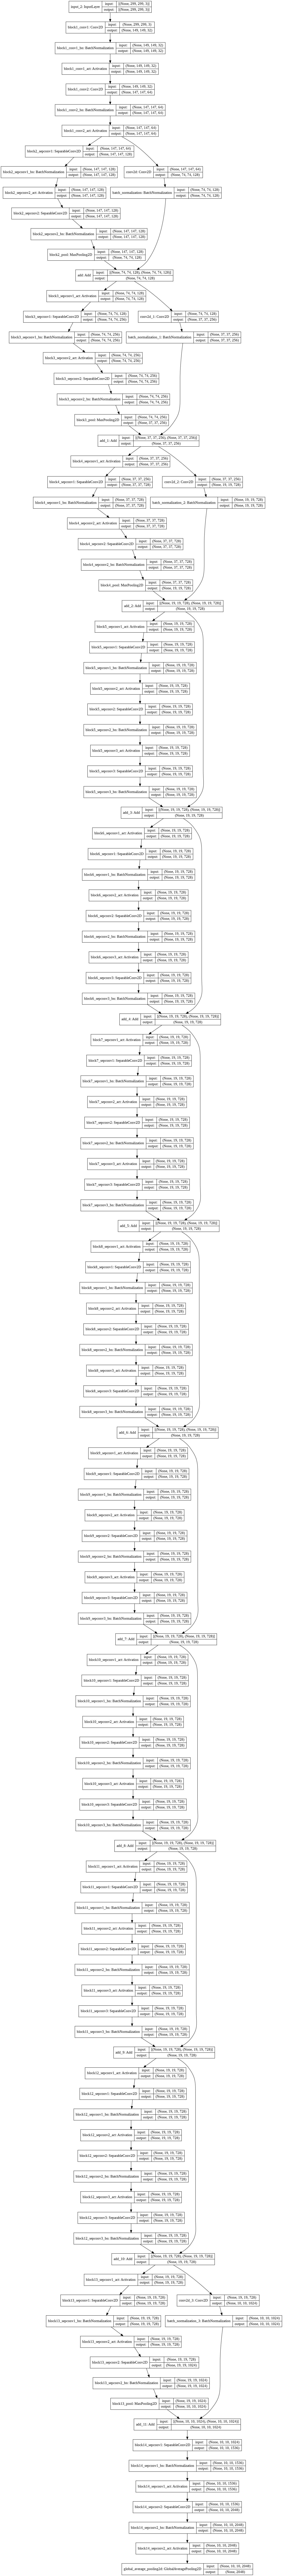

In [ ]:
tf.keras.utils.plot_model(pre_trained_model, show_shapes=True, show_layer_names=True)

### Compile Model

In [ ]:
#Obtaining last layer from Xception model. This will be connected to dense output layer

last_layer = pre_trained_model.layers[-1]
print(last_layer)
last_output = last_layer.output

In [ ]:
# x = layers.GlobalAveragePooling2D()(last_output)
# Flatten the output layer from inception to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
# Add a dropout rate of 0.35
x = layers.Dropout(0.35)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer =  opt, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=64,
        class_mode='binary',
        shuffle=True)

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir, 
        target_size=(299, 299), 
        batch_size=12,
        class_mode='binary',
        shuffle=True)

Found 658 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


## Preprocessing the image 

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
# Determine callback to stop training whether accuracy is reached. We set accuracy above 93%

class myCallback(tf.keras.callbacks.Callback):
  tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta = 0.1)
  def on_epoch_end(self, epoch, logs={}): # logs is the current state of training
    if(logs.get('val_accuracy')>0.93): #or if(logs.get('loss')<0.04) if we use parameter loss
      # the current loss is available in the logs, so we can query it for certain amount.
      print("\nReached 93% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()

## Training Model

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8, 
      callbacks =[callbacks] )

Epoch 1/10
10/10 [==============================] - 15s 2s/step - loss: 0.7588 - accuracy: 1.0000 - val_loss: 1.8502 - val_accuracy: 0.7812
Epoch 2/10
10/10 [==============================] - 15s 2s/step - loss: 0.7241 - accuracy: 0.9983 - val_loss: 1.5361 - val_accuracy: 0.8021
Epoch 3/10
10/10 [==============================] - 16s 2s/step - loss: 0.6912 - accuracy: 0.9984 - val_loss: 1.1579 - val_accuracy: 0.8750
Epoch 4/10
10/10 [==============================] - 16s 2s/step - loss: 0.6614 - accuracy: 0.9966 - val_loss: 1.1257 - val_accuracy: 0.8125
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 0.6293 - accuracy: 0.9983 - val_loss: 1.0648 - val_accuracy: 0.8854
Epoch 6/10
10/10 [==============================] - 16s 2s/step - loss: 0.6043 - accuracy: 0.9933 - val_loss: 1.2887 - val_accuracy: 0.8333
Epoch 7/10
10/10 [==============================] - 15s 2s/step - loss: 0.5734 - accuracy: 0.9983 - val_loss: 1.0814 - val_accuracy: 0.8646
Epoch 8/10
10/10 [==

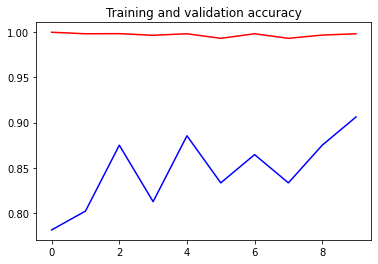

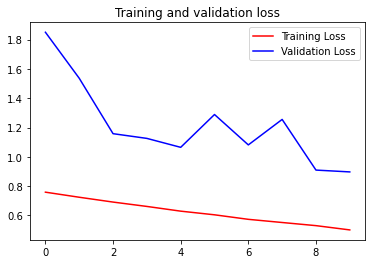

In [ ]:
# Plot loss and accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test Images

In [ ]:
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")


In [ ]:
print (train_generator.class_indices)

{'Great': 0, 'Poor': 1}


Saving 00002897.jpg to 00002897.jpg


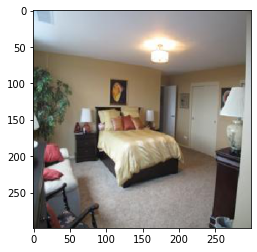

Poor: 0.16%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image

labels = sorted(train_generator.class_indices.keys(), reverse=True)

uploaded = files.upload()


for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  prob = model.predict(images)[0]
  # print(prob[0])
  
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, prob):
    print("{}: {:.2f}%".format(label, p * 100))
  

In [ ]:
  predict_labels = []
  if prob[0]>0.45:
    print(fn + " is poor")
    predict_labels.append(0)
  else:
    print(fn + " is rich")
    predict_labels.append(1)
    print (predict_labels)
x_list = predict_labels

00002897.jpg is rich
[1]


In [ ]:
#convert df to csv
df2 = pd.DataFrame({'bedroom_filename': fn,
                   'result': x_list})
df2.to_csv('/content/gdrive/Shareddrives/Capstone Project/Room Classification/Bedroom.csv', index=False, header=True)
pd.read_csv('/content/gdrive/Shareddrives/Capstone Project/Room Classification/Bedroom.csv')

,filename,result
0,00002966.jpg,1


In [ ]:
#merge csv
df1 = pd.read_csv('/content/gdrive/Shareddrives/Capstone Project/Room Classification/livingRoom.csv')
df2 = pd.read_csv('/content/gdrive/Shareddrives/Capstone Project/Room Classification/Kitchen.csv')
df3 = pd.read_csv('/content/gdrive/Shareddrives/Capstone Project/Room Classification/Bedroom.csv')
finaldf = pd.concat([df1, df2, df3], axis=1, join='outer')
print (finaldf)

#convert merge csv to one file csv
finaldf.to_csv('/content/gdrive/Shareddrives/Capstone Project/Room Classification/hasilKlasifikasi.csv')
pd.read_csv('/content/gdrive/Shareddrives/Capstone Project/Room Classification/hasilKlasifikasi.csv')

       filename  result      filename  result      filename  result
0  00000005.jpg       0  00002966.jpg       1  00002966.jpg       1


,Unnamed: 0,filename,result,filename.1,result.1,filename.2,result.2
0,0,00000005.jpg,0,00002966.jpg,1,00002966.jpg,1


## Save the model

In [ ]:
model_name = '/content/gdrive/Shareddrives/Capstone Project/Room Classification/model cloud/Bedroom_classification.pb'
model.save(model_name)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Load the model.
new_model= tf.keras.models.load_model(filepath="/content/gdrive/Shareddrives/Capstone Project/Room Classification/model cloud/Bedroom_classification.pb")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('/content/gdrive/Shareddrives/Capstone Project/Room Classification/model cloud/tfLite/Bedroom_trial.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmply49jo27/assets


In [ ]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/image_classification_mobilenet_v2/image_classification_mobilenet_v2.h5 \
  ./demos/public/models/image_classification_mobilenet_v2
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.